# News Article Validity Classification

In [13]:
from preprocessing.preprocess import load_and_process_data, split_data
from models.train import tokenize_text, build_model, train_model
from models.evaluate import evaluate_model
from utils.model_utils import load_model_and_tokenizer, preprocess_text, model_predict
from utils.explain_utils import generate_explanation, word_importance
import matplotlib.pyplot as plt
import json 
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
#Path of the JSONL
file_path = 'data/fine_data.jsonl'

#Read and process the data
df = load_and_process_data(file_path)

#Show the first rows of the dataframe
print(df.head())
print(df['label'].value_counts()) 

                                             content  label
0  XRP Price Prediction Bullish Sentiment Builds ...      0
1  CoinStats Suffers Major Security Breach 1590 C...      0
2  TON Ecosystem Faces Phishing Threats Blockchai...      1
3  Mt Gox to Repay Creditors in BTC and BCH Repay...      1
4  XRP Tokens in Massive Movement Internal Operat...      1
label
0    16
1    14
Name: count, dtype: int64


In [4]:
X_train, X_val, y_train, y_val = split_data(df)
print(f'Number of examples in the training set: {len(X_train)}')
print(f'Number of examples in the validation set: {len(X_val)}')

Number of examples in the training set: 24
Number of examples in the validation set: 6


Epoch 1/20
1/1 [==============================] - 12s 12s/step - loss: 0.7152 - accuracy: 0.4167 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 1s 609ms/step - loss: 0.7073 - accuracy: 0.5417 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 590ms/step - loss: 0.6969 - accuracy: 0.5417 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 1s 625ms/step - loss: 0.6861 - accuracy: 0.5417 - val_loss: 0.6776 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 1s 620ms/step - loss: 0.6759 - accuracy: 0.5417 - val_loss: 0.6647 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 1s 590ms/step - loss: 0.6607 - accuracy: 0.5417 - val_loss: 0.6483 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 1s 593ms/step - loss: 0.6457 - accuracy: 0.5417 - val_loss: 0.6253 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=====

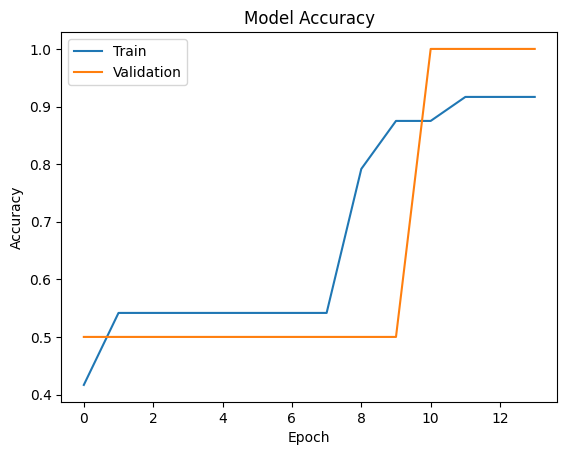

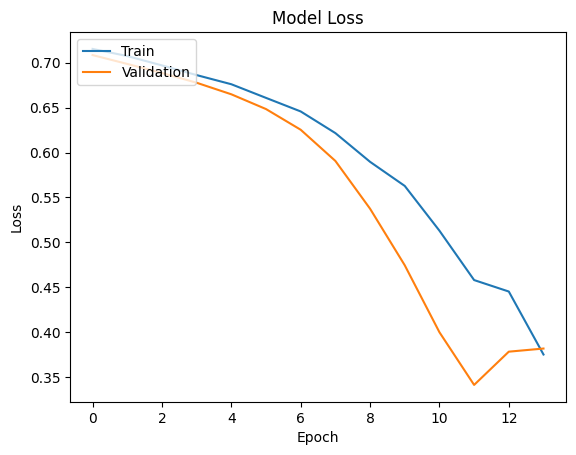

In [5]:
#Preprocess of the text
X_train_padded, X_val_padded, tokenizer = tokenize_text(X_train, X_val)

#Build and train of the model
model = build_model(max_length=X_train_padded.shape[1])
history, model = train_model(model, X_train_padded, y_train, X_val_padded, y_val)

#Evaluate the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
#Evaluate the model's performance
accuracy, precision, recall, f1 = evaluate_model(model, X_val_padded, y_val)
print("Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

1/1 [==============================] - 1s 671ms/step
Model Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [10]:
#Save the training model
model.save('news_article_validity_model.h5')

#Save the tokenizer 
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)

print("Model and tokenizer saved with success.")

Model and tokenizer saved with success.


c:\Users\rios1\OneDrive\Escritorio\NewsArticleValidityClassification\env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer('news_article_validity_model.h5', 'tokenizer.json')

# Define test data
X_test = [
    "SEC Drops Ethereum Investigation, Continues Pursuit of Ripple - Ethereum Cleared: The SEC has dropped its investigation into the Ethereum Foundation, determining that ETH is not a security token, paving the way for its entry into U.S. exchange-traded funds. - Ripple Dispute Continues: The SEC seeks a fine of over $100 million from Ripple, claiming XRP is a financial security, while Ripple proposes a $10 million fine, citing the Terraform Labs agreement. - Implications: The Ethereum decision opens the door for its listing on U.S. exchanges, while the Ripple case will determine if XRP is a security or not, with significant implications for the crypto industry.",
    "XRP Price Prediction: Bullish Sentiment Builds Amidst Legal Wins - XRP's Resilience: Despite ongoing legal battles, XRP's price remains buoyant, maintaining its top-five position. - Market Indicators: Increased open interest, liquidity, and low correlation to Bitcoin suggest a potential breakout. - Technical Analysis: Analysts predict a possible surge to $8 by July and $27 in six months based on bullish candle formations. - Long-term Projections: Predictions range from $17 by 2028 to over $2,000 by 2035, indicating significant growth potential. - Investor Caution: While signs are encouraging, investors should exercise caution and perform due diligence before making financial decisions."
]
# Preprocess test data
X_test_padded = preprocess_text(X_test, tokenizer, maxlen=100)

# Create a wrapper function for the model
f = lambda x: model_predict(model, x).flatten()

# Initialize the SHAP explainer
explainer = shap.KernelExplainer(f, X_test_padded[:1000])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_padded)

# Make predictions
predictions = model_predict(model, X_test_padded)

# Print predictions and explanations
for text, pred, shap_vals in zip(X_test, predictions, shap_values):
    # Generate SHAP explanation
    explanation = generate_explanation(text, pred[0], shap_vals, tokenizer)
    print(f"Text: {text}")
    print(f"Explanation (SHAP): {explanation}")
    
    # Compute word importance
    importances = word_importance(text, model, tokenizer,100)
    top_words = importances[:5]
    
    validity = "Valid" if pred >= 0.5 else "Invalid"
    print(f"Prediction: {pred[0]:.4f}")
    print(f"Clasificación: {validity}")
    print("Top contributing words:", ", ".join([f"{word} ({val:.6f})" for word, val in top_words]))
    print()

Model and tokenizer loaded successfully.
1/1 [==============================] - 1s 678ms/step


  0%|          | 0/2 [00:00<?, ?it/s]

141/141 [==============================] - 8s 56ms/step


 50%|█████     | 1/2 [00:08<00:08,  8.36s/it]

141/141 [==============================] - 7s 50ms/step


100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

1/1 [==============================] - 0s 67ms/step


Text: SEC Drops Ethereum Investigation, Continues Pursuit of Ripple - Ethereum Cleared: The SEC has dropped its investigation into the Ethereum Foundation, determining that ETH is not a security token, paving the way for its entry into U.S. exchange-traded funds. - Ripple Dispute Continues: The SEC seeks a fine of over $100 million from Ripple, claiming XRP is a financial security, while Ripple proposes a $10 million fine, citing the Terraform Labs agreement. - Implications: The Ethereum decision opens the door for its listing on U.S. exchanges, while the Ripple case will determine if XRP is a security or not, with significant implications for the crypto industry.
Explanation (SHAP): This article was classified as valid (probability: 0.7001). The main contributing words were: The (0.0102), the (0.0102), the (0.0102), The (0.0102), the (0.0102)
1/1 [==============================] - 0s 43ms/step
Prediction: 0.7001
Clasificación: Valid
Top contributing words: exchange-traded (0.006006), 